# Astronomaly

This notebook is designed to replicate the feature extraction methods of Astronomaly. In addition, the steps are shown individually and explained in order to provide better detail in the processes of Astronomaly. The notebook would thus ideally serve as a troubleshooting method for Astronomaly.

## Section 1: Using A Sample From Astronomaly

This section displays the contours and ellipses found by Astronomaly. The image within this section is taken directly from Astronomaly and the contours and ellipses are shown for this image. The image has already been transformed before it is obtained and as such the separate transformations can not be displayed here.

__________________________

In [62]:
from astronomaly.anomaly_detection import isolation_forest, human_loop_learning
from astronomaly.base import logging_tools
from astronomaly.base.base_pipeline import PipelineStage
from astronomaly.data_management import image_reader
from astronomaly.dimensionality_reduction import pca
from astronomaly.feature_extraction import power_spectrum, autoencoder, shape_features
from astronomaly.feature_extraction.shape_features import find_contours, fit_ellipse, draw_contour
from astronomaly.feature_extraction.shape_features import get_ellipse_leastsq, extract_contour
from astronomaly.postprocessing import scaling
from astronomaly.preprocessing import image_preprocessing
from astronomaly.preprocessing.image_preprocessing import image_transform_sigma_clipping, image_transform_scale
from astronomaly.visualisation import tsne
from astronomaly.utils import utils

import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

_______________________

In [2]:
def image_transform_greyscale(img):
    """
    Simple function that combines the rgb bands into a single image.

    Parameters
    ----------
    img : np.ndarray
        Input image

    Returns
    -------
    np.ndarray
        Greyscale image

    """

    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    return img

_______________________

### Setting up the data

#### This subsection contains all of the relevant data and parameters that are to be specified in order for Astronomaly to run. 

Selecting the data brick to be used:

In [3]:
coadd_id = '0260'  # Brick code

Some default settings for Astrnomaly to use on optical data

In [4]:
list_of_files = []
window_size = 32
band_prefixes = ['z-', 'r-', 'g-']
bands_rgb = {'r': 'z-', 'g': 'r-', 'b': 'g-'}
plot_cmap = 'hot'
feature_method = 'ellipse'
dim_reduction = ''

Selecting the transform functions

In [5]:
image_transform_function = [image_transform_greyscale,
                            image_preprocessing.image_transform_sigma_clipping,
                            # image_preprocessing.image_transform_inverse_sinh,
                            image_preprocessing.image_transform_scale
                           ]

display_transform_function = [# image_preprocessing.image_transform_inverse_sinh
                              image_preprocessing.image_transform_scale
                             ]

The data directory can be set up to shorten other directories and assists in sorting out the data storage. Due to the large number of bricks involved, it is much simpler to merely change the brick name than the entire directory all the time

In [6]:
data_dir = '/home/verlon/Desktop/Astronomaly/Data/Coadd_'+str(coadd_id)+'/'

In [7]:
image_dir = os.path.join(data_dir, '0260m062', 'Input', 'Images')
output_dir = os.path.join(data_dir, '0260m062', 'Output', '')

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

Selecting the catalogue (as created by the convert_tractor_catalogue function in utils.py)

In [8]:
catalogue = pd.read_csv(os.path.join(
    data_dir, '0260m062', 'Input', 'test_catalogue_0260m062_500.csv'))

________________________________________

## Running Astronomaly

In [9]:
image_dataset = image_reader.ImageDataset(directory=image_dir,
                                          list_of_files=list_of_files,
                                          window_size=window_size,
                                          output_dir=output_dir,
                                          plot_square=False,
                                          transform_function=image_transform_function,
                                          display_transform_function=display_transform_function,
                                          plot_cmap=plot_cmap,
                                          catalogue=catalogue,
                                          band_prefixes=band_prefixes,
                                          bands_rgb=bands_rgb)

Reading image data from /home/verlon/Desktop/Astronomaly/Data/Coadd_0260/0260m062/Input/Images/z-legacysurvey-0260m062-image.fits.fz...


2020-10-15 17:42:06,794 - WARNING - FITSFixedWarning: 'datfix' made the change 'Set DATE-REF to '1858-11-17' from MJD-REF'.


Done!
A catalogue of  500 sources has been provided.


__________________________

This is where a sample is selected. This sample is already transformed as per the image transform function. To see the indices applicable, use *image_dataset.metadata.index*.

In [10]:
ind = '1487'

In [11]:
image = image_dataset.get_sample(ind)

In [12]:
plt.figure(figsize=(8, 8))
plt.imshow(image)

Select the percentiles to be used. These percentiles divide the image into regions based on the image array values. It is these percentiles that determine the location of the contours that are to be drawn.

In [13]:
percentiles = [90, 80, 70, 60, 50, 0]

___________________

This is the function that reads in the percentiles on the relevant image, obtains the contours and finds the corresponding ellipses to these contours.

In [14]:
percentiles = np.sort(percentiles)[::-1]

feats = []
threshold = []
all_contours = []
all_ellipses = []

x0 = y0 = -1
x_cent = image.shape[0] // 2
y_cent = image.shape[1] // 2

if np.all(image == 0):
    failed = True
    failure_message = "Invalid cutout for feature extraction"
else:
    failed = False
    failure_message = ""

for p in percentiles:
    if failed:
        contours = []
    else:
        thresh = np.percentile(image[image > 0], p)
        contours, hierarchy = find_contours(image, thresh)

        x_contours = np.zeros(len(contours))
        y_contours = np.zeros(len(contours))

    if len(contours) != 0:
        for k in range(len(contours)):
            M = cv2.moments(contours[k])
            try:
                x_contours[k] = int(M["m10"] / M["m00"])
                y_contours[k] = int(M["m01"] / M["m00"])
            except ZeroDivisionError:
                pass
        if x0 == -1:
            x_diff = x_contours - x_cent
            y_diff = y_contours - y_cent
        else:
            x_diff = x_contours - x0
            y_diff = y_contours - y0

        # Will try to find the CLOSEST contour to the central one
        r_diff = np.sqrt(x_diff**2 + y_diff**2)

        ind = np.argmin(r_diff)

        if x0 == -1:
            x0 = x_contours[ind]
            y0 = y_contours[ind]

        c = contours[ind]

        params = get_ellipse_leastsq(c, image)
        print('Parameter = ', params)

        # Params return in this order:
        # residual, x0, y0, maj_axis, min_axis, theta
        if np.any(np.isnan(params)):
            failed = True
        else:
            if params[3] == 0 or params[4] == 0:
                aspect = 1
            else:
                aspect = params[4] / params[3]

            if aspect < 1:
                aspect = 1 / aspect
            if aspect > 100:
                aspect = 1

            new_params = params[:3] + [aspect] + [params[-1]]
            feats.append(new_params)

        arr = image.copy()

        ellipse_arr, param = fit_ellipse(
            c, image, return_params=True, filled=False)

        all_ellipses.append(ellipse_arr)
        all_contours.append(c)

    else:
        failed = True
        failure_message = "No contour found"

Parameter =  [0.009765625, 16.378143310546875, 16.780231475830078, 4.902750492095947, 5.636335372924805, 114.36402130126953]
Parameter =  [0.01171875, 16.39434051513672, 16.743324279785156, 6.733417510986328, 8.424287796020508, 97.11046600341797]
Parameter =  [0.0146484375, 16.53602409362793, 16.739534378051758, 8.06382942199707, 10.488739013671875, 102.77694702148438]
Parameter =  [0.0244140625, 16.60857582092285, 16.58002281188965, 9.56072998046875, 12.058088302612305, 100.15540313720703]
Parameter =  [0.0234375, 16.498546600341797, 16.406463623046875, 10.428736686706543, 13.895791053771973, 95.63238525390625]
Parameter =  [0.0771484375, 15.418497085571289, 17.145301818847656, 17.555484771728516, 18.88165283203125, 38.91754913330078]


___________________________

This is used to see what the contours and ellipses look like for the given image.

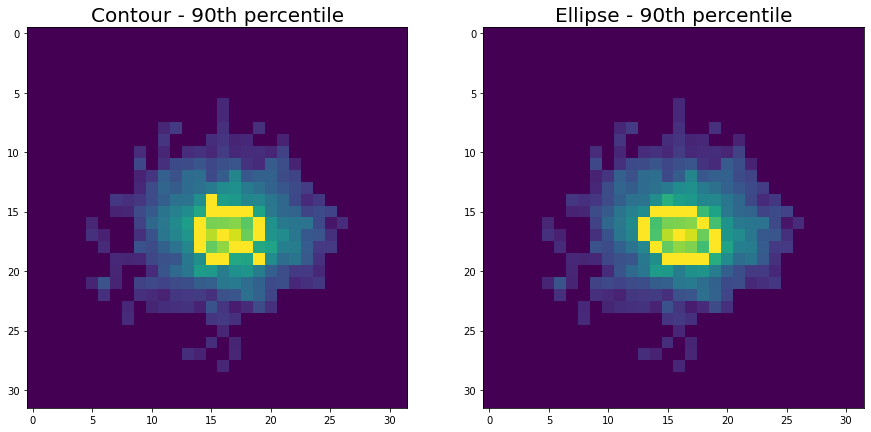

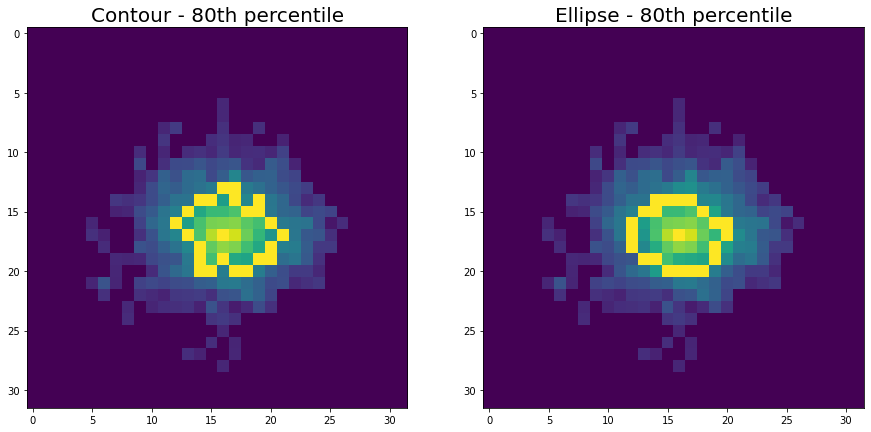

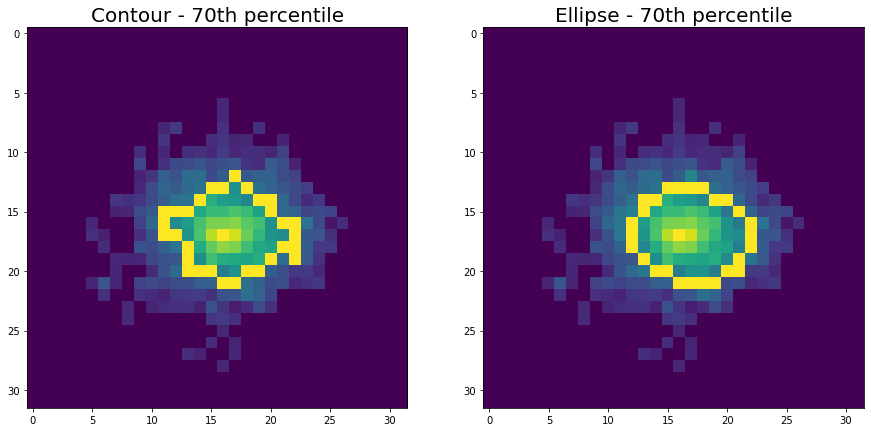

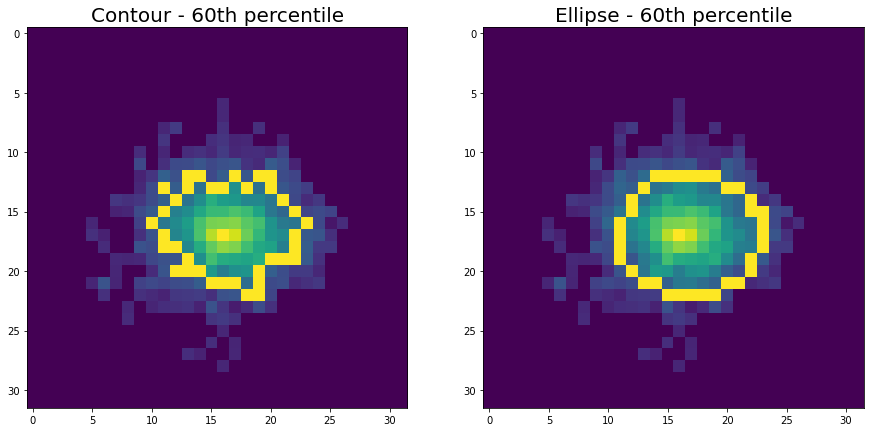

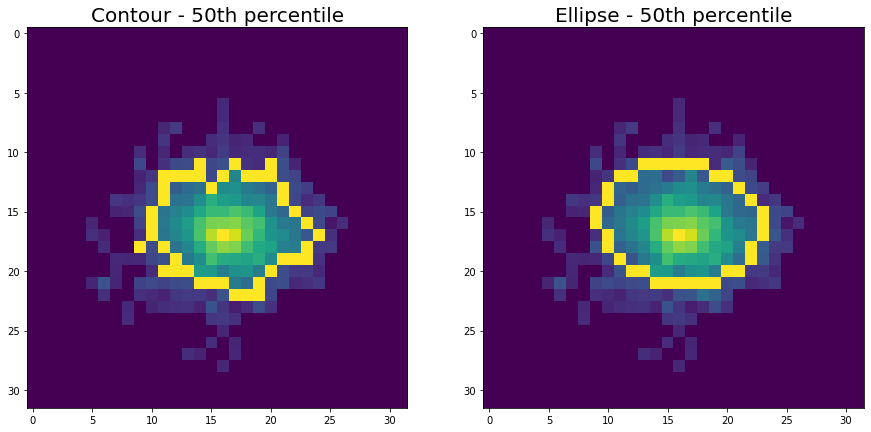

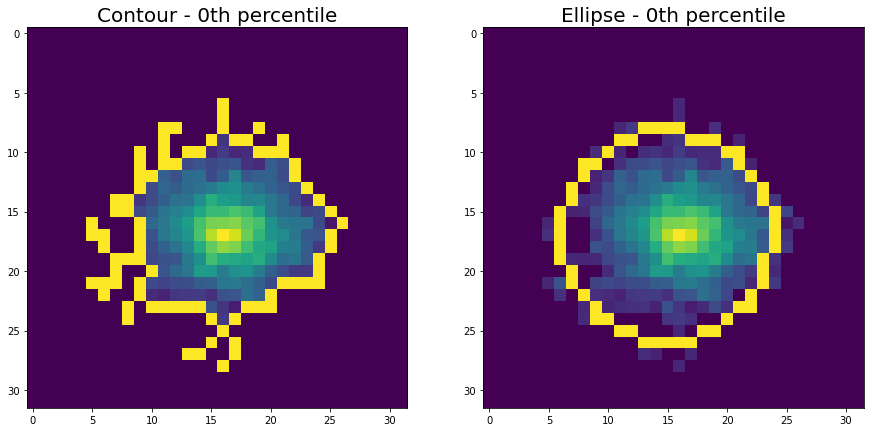

In [15]:
%matplotlib inline

for i in range(len(all_contours)):
    drawn = draw_contour(all_contours[i], image)

    f = plt.figure(figsize=(15, 15))

    f.add_subplot(1, 2, 1)
    plt.imshow(drawn)
    plt.gca().set_title('Contour - ' +
                        str(percentiles[i]) + 'th percentile', fontsize=20)

    f.add_subplot(1, 2, 2)
    plt.imshow(all_ellipses[i])
    plt.gca().set_title('Ellipse - ' +
                        str(percentiles[i]) + 'th percentile', fontsize=20)

    plt.show(block=True)

_______________

## Section 2: Using A Cutout From The Legacy Skyviewer.

This section applies the same procedure as Astronomaly on a cutout from the Legacy Skyviewer. The image transformation process can thus be displayed step by step. This assists in troubleshooting if needed.

________________

In [53]:
cutout = '/home/verlon/Desktop/Astronomaly/Data/Coadd_0260/0260m062/Input/Failed Images/cutout_26.0835_-6.3682.fits'

In [54]:
image = fits.getdata(cutout)

This image contains three bands, displayed below for more detail.

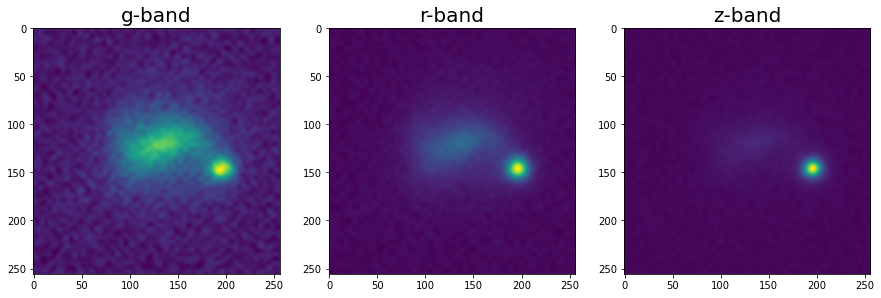

In [55]:
f = plt.figure(figsize=(15, 15))

f.add_subplot(1, 3, 1)
plt.imshow(image[0, :, :])
plt.gca().set_title('g-band', fontsize=20)

f.add_subplot(1, 3, 2)
plt.imshow(image[1, :, :])
plt.gca().set_title('r-band', fontsize=20)

f.add_subplot(1, 3, 3)
plt.imshow(image[2, :, :])
plt.gca().set_title('z-band', fontsize=20)

plt.show(block=True)

_________________

## Applying The Image Transformation Functions

#### Greyscale Transform

The first transformation done is the greyscale transform. This is required so as to join all three separate bands together and thus minimizes data loss.

In [56]:
one = image[0,:,:] # g-band - blue b
two = image[1,:,:] # r-band - green g
three = image[2,:,:] # z-band - red r

In [57]:
rgb_image = np.dstack((three,two,one)) #RGB IMAGE
bgr_image = np.dstack((one,two,three)) #BGR IMAGE
image_grey = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2GRAY)

2020-10-15 17:54:29,884 - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2020-10-15 17:54:29,926 - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


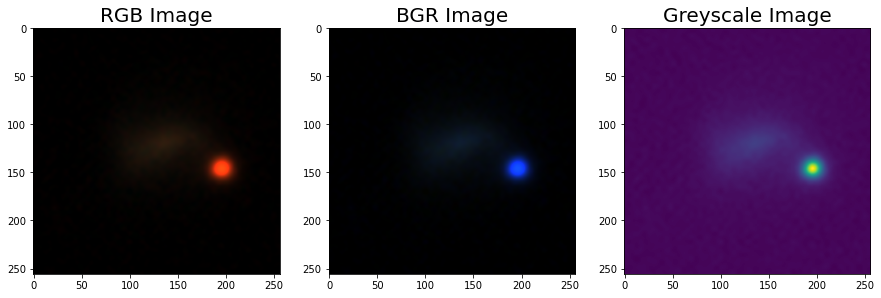

In [59]:
f = plt.figure(figsize=(15, 15))

f.add_subplot(1, 3, 1)
plt.imshow(rgb_image)
plt.gca().set_title('RGB Image', fontsize=20)

f.add_subplot(1, 3, 2)
plt.imshow(bgr_image)
plt.gca().set_title('BGR Image', fontsize=20)

f.add_subplot(1, 3, 3)
plt.imshow(image_grey)
plt.gca().set_title('Greyscale Image', fontsize=20)

plt.show(block=True)

#### Sigma Clipping

Sigma clipping removes background noise as well as compensates for nearby objects. It is needed to remove any interference.

In [47]:
image_sigma_clipped = image_transform_sigma_clipping(image)

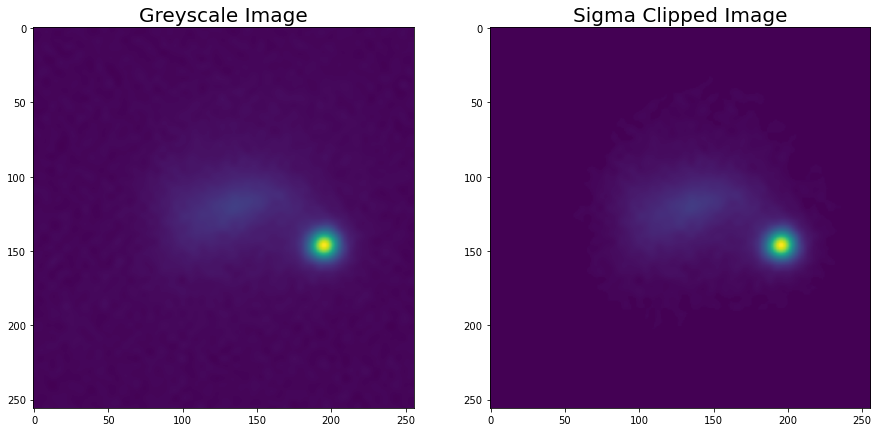

In [49]:
f = plt.figure(figsize=(15, 15))

f.add_subplot(1, 2, 1)
plt.imshow(image_grey)
plt.gca().set_title('Greyscale Image', fontsize=20)

f.add_subplot(1, 2, 2)
plt.imshow(image_sigma_clipped)
plt.gca().set_title('Sigma Clipped Image', fontsize=20)

plt.show(block=True)

#### Scale Transform

This transformation normalises the image so that the array values are between 0 and 1. This is useful for deep learning.

In [63]:
image_transform = image_transform_scale(image_sigma_clipped)

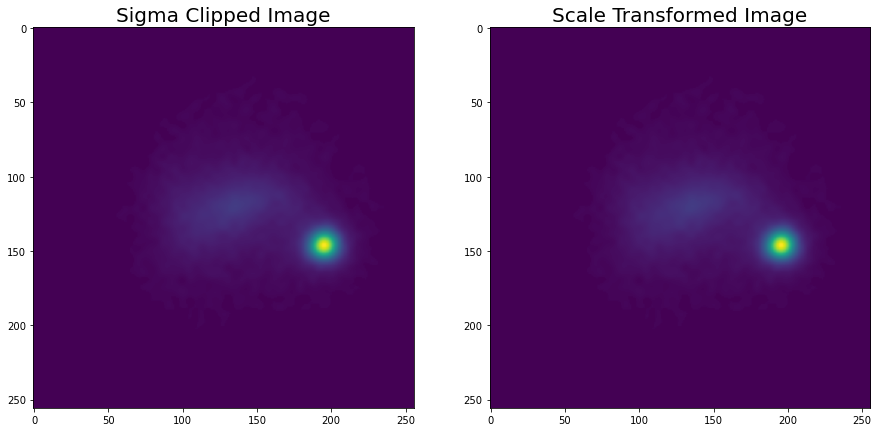

In [64]:
f = plt.figure(figsize=(15, 15))

f.add_subplot(1, 2, 1)
plt.imshow(image_sigma_clipped)
plt.gca().set_title('Sigma Clipped Image', fontsize=20)

f.add_subplot(1, 2, 2)
plt.imshow(image_transform)
plt.gca().set_title('Scale Transformed Image', fontsize=20)

plt.show(block=True)

_________________________